## Stacking

In [1]:
import pandas as pd, numpy as np, os
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
PATH = '../preds/'
FILES = os.listdir(PATH)

oof_files = np.sort([f for f in FILES if 'oof' in f and 'extra2' in f and 'five' not in f])
oof_preds = [np.load(PATH + k) for k in oof_files]

print(f'We have {len(oof_preds)} OOF files...')
print(oof_files)

We have 4 OOF files...
['model_four_extra2_oof.npy' 'model_one_extra2_oof.npy'
 'model_three_extra2_oof.npy' 'model_two_extra2_oof.npy']


## OOF predictions

In [3]:
x = np.vstack(oof_preds).T
x.shape

(9875, 4)

In [4]:
x

array([[45.3125    , 47.8515625 , 48.4375    , 47.65625   ],
       [25.78125   , 26.5625    , 23.33984375, 25.390625  ],
       [58.984375  , 62.109375  , 60.9375    , 61.71875   ],
       ...,
       [28.125     , 26.7578125 , 27.1484375 , 28.515625  ],
       [27.1484375 , 26.171875  , 26.3671875 , 27.1484375 ],
       [38.671875  , 35.3515625 , 37.890625  , 38.8671875 ]])

## Statistical properties of OOF predictions

In [5]:
preds_min = x.min(axis=1).reshape(-1, 1)
preds_max = x.max(axis=1).reshape(-1, 1)
preds_range = preds_max - preds_min
preds_mean = x.mean(axis=1).reshape(-1, 1)
preds_median = np.median(x, axis=1).reshape(-1, 1)
preds_std = x.std(axis=1).reshape(-1, 1)
from scipy.stats import skew
preds_skew = skew(x, axis=1).reshape(-1, 1)


x = np.concatenate([x, preds_min, preds_max, preds_range, preds_mean, preds_median, preds_std, preds_skew], axis=1)

In [6]:
x.shape

(9875, 11)

## Under 20

In [7]:
under_20 = np.load("../preds/model_five_oof.npy").reshape(-1, 1)
under_20 = np.where(under_20 > 0.4, 1, 0)
x = np.concatenate([x, under_20], axis=1)
x.shape

(9875, 12)

In [68]:
yup = y_true.reshape(-1, 1)[np.where(under_20 > 0.3, True, False)]
(yup < 20).sum() #/ yup.shape[0]

208

In [56]:
np.where(under_20 > 0.3, True, False)

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

In [50]:
(y_true[np.where(under_20 > 0.3, 1, 0)] < 20).sum()

0

## Meta-data provided by organizers

In [12]:
df = pd.read_csv('../data/train_folds.csv')
y_true = []
other_feats = []
for i in range(5):
    y_true.extend(df[df.kfold == i].Pawpularity.values.tolist())
    other_feats.extend(df[df.kfold == i][[
        "Subject Focus", "Eyes", "Face", "Near", "Action", "Accessory", "Group", "Collage", "Human", "Occlusion", "Info", "Blur"
    ]].values)
y_true = np.array(y_true)
x_feats = np.array(other_feats)

In [13]:
x_feats.shape

(9875, 12)

In [14]:
x_feats

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [15]:
x = np.concatenate([x, x_feats], axis=1)
x.shape

(9875, 24)

## More image meta-data

In [16]:
# from PIL import Image


# img_feats = [] 
# for i in range(5):
#     image_fpaths = [f'../data/train/{i}.jpg' for i in df[df.kfold == i].Id.tolist()]
#     img_shape = np.array([np.array(Image.open(img).size) for img in image_fpaths])
#     img_aspect_ratio = (img_shape[:, 0] / img_shape[:, 1]).reshape(-1, 1)
#     img_mean = np.array([np.array(Image.open(img)).mean() for img in image_fpaths]).reshape(-1, 1)
#     img_feats.extend(np.hstack([img_shape, img_aspect_ratio, img_mean]))

# img_feats = np.array(img_feats)

In [17]:
# img_feats

In [18]:
# x = np.concatenate([x, img_feats], axis=1)
# x.shape

## Set up Cross Validation

In [19]:
from sklearn.model_selection import PredefinedSplit

cv = PredefinedSplit(df.kfold)

## Train meta-model

#### GradientBoostingRegressor

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor()
parameters = {
    'n_estimators': [100, 300, 500],
    'learning_rate':[0.01, 0.01, 0.1, 1],
    'max_depth':[3, 5, 7],
    'max_features': ["auto", "sqrt", "log2"]
}
clf = GridSearchCV(reg, parameters, n_jobs=-1, cv=cv, scoring='neg_root_mean_squared_error')
grid = clf.fit(x, y_true)

In [21]:
grid.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'max_features': 'log2',
 'n_estimators': 300}

In [22]:
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
 
y_pred = []
y_real = []

for train_idx, val_idx in cv.split():
    x_train, y_train = x[train_idx, :], y_true[train_idx]
    
    lr = GradientBoostingRegressor(**grid.best_params_)
    lr.fit(X=x_train, y=y_train)
    
    x_val = x[val_idx, :]
    preds = lr.predict(x_val)
    
    y_pred.extend(preds)
    y_real.extend(y_true[val_idx])

In [23]:
np.min(y_pred), np.max(y_pred)

(23.291549370422885, 83.52245880365601)

In [24]:
mean_squared_error(y_real, np.clip(y_pred, a_min=0, a_max=100), squared=False)

17.173653590224564

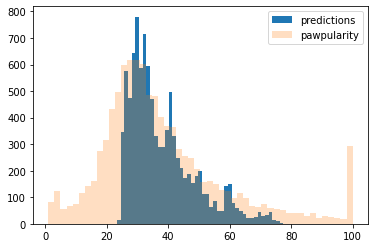

In [25]:
plt.hist(y_pred, bins=50, label='predictions');
plt.hist(y_real, bins=50, alpha=.25, label='pawpularity');
plt.legend();

#### RandomForest

In [26]:
reg = RandomForestRegressor()
parameters = {
    'n_estimators': [100, 300, 500],
    'max_depth':[3, 5, 7],
    'max_features': ["auto", "sqrt", "log2"]
}
clf = GridSearchCV(reg, parameters, n_jobs=-1, cv=cv, scoring='neg_root_mean_squared_error')
grid = clf.fit(x, y_true)

In [27]:
grid.best_params_

{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}

In [28]:
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
 
y_pred = []
y_real = []

for train_idx, val_idx in cv.split():
    x_train, y_train = x[train_idx, :], y_true[train_idx]
    
    lr = RandomForestRegressor(**grid.best_params_)
    lr.fit(X=x_train, y=y_train)
    
    x_val = x[val_idx, :]
    preds = lr.predict(x_val)
    
    y_pred.extend(preds)
    y_real.extend(y_true[val_idx])

In [29]:
np.min(y_pred), np.max(y_pred)

(22.422293012640644, 82.45152101192336)

In [30]:
mean_squared_error(y_real, np.clip(y_pred, a_min=0, a_max=100), squared=False)

17.163700284941918

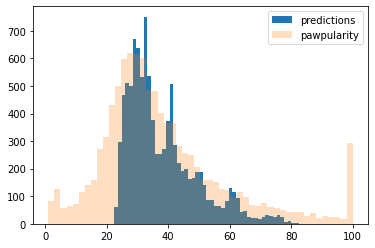

In [31]:
plt.hist(y_pred, bins=50, label='predictions');
plt.hist(y_real, bins=50, alpha=.25, label='pawpularity');
plt.legend();

#### Lasso

In [32]:
from sklearn.linear_model import LassoCV

In [33]:
lr = LassoCV(fit_intercept=True, normalize=True, cv=cv, random_state=1010)

In [34]:
lr.fit(X=x, y=y_true)

LassoCV(cv=PredefinedSplit(test_fold=array([0, 2, ..., 1, 4])), normalize=True,
        random_state=1010)

In [41]:
lr.alpha_, lr.coef_

(0.0018669279409013054,
 array([ 0.08810213,  0.38833068,  0.24061249,  0.        ,  0.13401663,
         0.        ,  0.        ,  0.12718641,  0.04505743,  0.        ,
        -0.        , -4.00383185, -0.        ,  0.25914884,  0.        ,
         0.5672964 , -0.        , -0.        , -0.16602175,  0.        ,
         0.        ,  0.        , -0.        , -1.43496799]))

In [36]:
y_pred = np.clip(lr.predict(X=x), a_min=0, a_max=100)

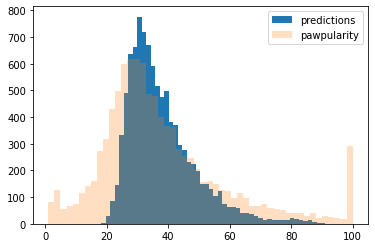

In [37]:
plt.hist(y_pred, bins=50, label='predictions');
plt.hist(y_true, bins=50, alpha=.25, label='pawpularity');
plt.legend();

In [38]:
mean_squared_error(y_true, y_pred, squared=False)

17.144652938844256

In [39]:
all = []
for k in range(x.shape[1]):
    rmse = mean_squared_error(y_true, x[:, k], squared=False)
    all.append(rmse)
    print('Model %i has OOF RMSE = %.4f'%(k, rmse))
    
m = [np.argmin(all)]; w = []

Model 0 has OOF RMSE = 17.3479
Model 1 has OOF RMSE = 17.2234
Model 2 has OOF RMSE = 17.2713
Model 3 has OOF RMSE = 17.2824
Model 4 has OOF RMSE = 17.3218
Model 5 has OOF RMSE = 17.3801
Model 6 has OOF RMSE = 39.6572
Model 7 has OOF RMSE = 17.1871
Model 8 has OOF RMSE = 17.1922
Model 9 has OOF RMSE = 41.8478
Model 10 has OOF RMSE = 43.2772
Model 11 has OOF RMSE = 43.1726
Model 12 has OOF RMSE = 43.2540
Model 13 has OOF RMSE = 42.6031
Model 14 has OOF RMSE = 42.4844
Model 15 has OOF RMSE = 42.5227
Model 16 has OOF RMSE = 43.2686
Model 17 has OOF RMSE = 43.2167
Model 18 has OOF RMSE = 43.1621
Model 19 has OOF RMSE = 43.2344
Model 20 has OOF RMSE = 43.1322
Model 21 has OOF RMSE = 43.1276
Model 22 has OOF RMSE = 43.2248
Model 23 has OOF RMSE = 43.2187
